In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.utils import to_categorical
from sklearn.model_selection import TimeSeriesSplit
import datetime
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
stockFileNames=os.listdir('./Stocks/')

In [3]:
stockSymbol=[]
col_names=['Date','Open','High','Low','Close','Volume','c']
dataList=list()
for f in stockFileNames:
    symbol=[str.upper(f.split('.')[0])]
    fileName='./Stocks/'+f
    fp=open(fileName,'r')
    if len(fp.read())>0:
        data=np.array(pd.read_csv(fileName,header=None))
        for d in data[1:]:
            dataList.append(d)
            stockSymbol.append(symbol)
        
    fp.close()
print('DONE!!')

DONE!!


In [4]:
np.shape(dataList),np.shape(stockSymbol)

((14887665, 7), (14887665, 1))

In [5]:
df1=pd.DataFrame(dataList,columns=col_names)
df2=pd.DataFrame(stockSymbol,columns=['SYMBOL'])

In [6]:
AllSymbolList=np.unique(df2)
df=pd.concat([df1,df2],axis=1)
df.head(5)
df['Date'][:10]

0    2017-01-03
1    2017-01-04
2    2017-01-05
3    2017-01-06
4    2017-01-09
5    2017-01-10
6    2017-01-11
7    2017-01-12
8    2017-01-13
9    2017-01-17
Name: Date, dtype: object

In [7]:
allCloseDF=df[['Date','Close','SYMBOL']]
allCloseDF.head(5)

,Date,Close,SYMBOL
0,2017-01-03,24.692,OUSM
1,2017-01-04,25.026,OUSM
2,2017-01-05,24.849,OUSM
3,2017-01-06,24.781,OUSM
4,2017-01-09,24.572,OUSM


In [8]:
def getCloseDataFromSymbols(df,symbol_list):
    return df[df['SYMBOL'].isin(symbol_list)][['Date','Close']]

resultDF=getCloseDataFromSymbols(allCloseDF,['AMZN','FB','GOOGL','NFLX'])
len(resultDF)

13068

In [9]:
AllSymbolList=np.unique(df2)
df=pd.concat([df1,df2],axis=1)
df.head(5)

,Date,Open,High,Low,Close,Volume,c,SYMBOL
0,2017-01-03,24.88,24.88,24.568,24.692,12957,0,OUSM
1,2017-01-04,24.732,25.944,24.732,25.026,10840,0,OUSM
2,2017-01-05,25.874,25.874,24.8,24.849,13104,0,OUSM
3,2017-01-06,24.82,24.858,24.771,24.781,2069,0,OUSM
4,2017-01-09,24.79,24.79,24.572,24.572,17870,0,OUSM


In [10]:
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
scaler = MinMaxScaler(feature_range=(0, 1))

def getPastSequenceData(df,window):
    #df=np.array(df)
    X=[]
    y=[]
    p = scaler.fit_transform(np.array(df['Close']).reshape(-1,1)) 
    #shuffle(p)
    for i in range(1,len(df)-window,window):
        #print(df[i-1:i+window-1],df[i+window-1])
        date=df['Date'].iloc[i]
        date=date.replace('-','')
        #print(date)
        date=np.array(date)
        vals=np.array(p[i-1:i+window-1])
        temp=vals
        X.append(temp)
        y.append(p[i+window-1])
    return X,y

In [33]:
#resultDF = scaler.fit_transform(resultDF)

X,y=getPastSequenceData(resultDF,8)
X=np.array(X)

X=X.reshape(X.shape[0],X.shape[1],1)
y=np.array(y)
np.shape(X),np.shape(y)


((1633, 8, 1), (1633, 1))

In [34]:
tsSplit=TimeSeriesSplit(n_splits=5)
for train_index,test_index in tsSplit.split(X):
    X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = y[:len(train_index)], y[len(train_index): (len(train_index)+len(test_index))]
print(X_train.shape)

(1361, 8, 1)


In [42]:
from keras.layers import Conv1D, Activation,MaxPooling1D,Flatten, GRU, AveragePooling1D

def createLSTM():
    model=Sequential()
    model.add(Conv1D(32, 3, padding='same', input_shape =X_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv1D(32, 3, padding='same'))
    model.add(Activation('elu'))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(64, 3, padding='same', input_shape =X_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv1D(64, 3, padding='same'))
    model.add(Activation('elu'))
    model.add(AveragePooling1D(pool_size=2))
    #model.add(GRU(200,input_shape=(8,1),return_sequences=True))
    model.add(GRU(200, return_sequences= True))
    model.add(GRU(100))
    model.add(Dense(200))
    model.add(Dropout(0.20))
    model.add(Dense(50))
    model.add(Dropout(0.20))
    model.add(Dense(1))
    return model

In [43]:

model=createLSTM()
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 8, 32)             128       
_________________________________________________________________
activation_17 (Activation)   (None, 8, 32)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 8, 32)             3104      
_________________________________________________________________
activation_18 (Activation)   (None, 8, 32)             0         
_________________________________________________________________
average_pooling1d_9 (Average (None, 4, 32)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 4, 64)             6208      
_________________________________________________________________
activation_19 (Activation)   (None, 4, 64)             0         
__________

In [44]:


model.compile(loss='mse',optimizer='adam',metrics=['acc'])
model.fit(X_train,y_train,epochs=300,verbose=1, batch_size = 32)



Epoch 1/300
1361/1361 [==============================] - 1s 792us/step - loss: 0.0054 - acc: 0.0000e+00
Epoch 2/300
1361/1361 [==============================] - 0s 231us/step - loss: 0.0021 - acc: 0.0000e+00

In [45]:
model.evaluate(X_test,y_test)

272/272 [==============================] - 0s 967us/step


[5.381149179918473e-05, 0.0]

In [46]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)


# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)
#print(testPredict[400:],'\n\n\n\n',testY[400:])



Average Training Difference: 3.46 
Average Testing Difference: 6.46 


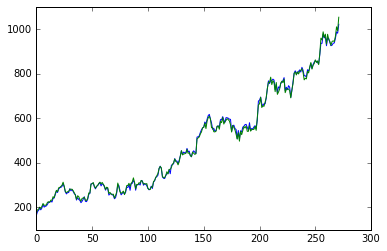

In [47]:

trainScore=0
testScore=0
# calculate root mean squared error
for i in range (trainY.shape[0]):
    trainScore += math.sqrt(mean_squared_error(trainY[i], trainPredict[i]))
trainScore=trainScore/trainY.shape[0]

for i in range (testY.shape[0]):
    testScore += math.sqrt(mean_squared_error(testY[i],testPredict[i]))
testScore=testScore/testY.shape[0]

print('Average Training Difference: %.2f ' % (trainScore))
print('Average Testing Difference: %.2f ' % (testScore))
# for i in range(testPredict.shape[0]):
#     if testPredict[i] > 1000:
#         print testPredict[i]
plt.plot(testPredict)

plt.plot(testY)
plt.show()


In [19]:
model.save("best-Huge-model-C-RNN.hdf5")